# Transfer learning resnet18 on mnist numbers

In [1]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers 
import os, warnings
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=21):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
#plt.rc('axes', labelweight='bold', labelsize='large', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


2022-09-25 16:48:26.370856: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-25 16:48:26.491671: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-25 16:48:27.012864: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64:
2022-09-25 16:48:27.012914: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libn

In [2]:
! wandb login

wandb: Currently logged in as: gratkadlafana. Use `wandb login --relogin` to force relogin


In [3]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="phcd_numbers", name='tf_resnet50_mnist')

wandb: Currently logged in as: gratkadlafana. Use `wandb login --relogin` to force relogin


2022-09-25 16:48:32.725974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-25 16:48:32.729614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-25 16:48:32.729796: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-25 16:48:32.730307: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

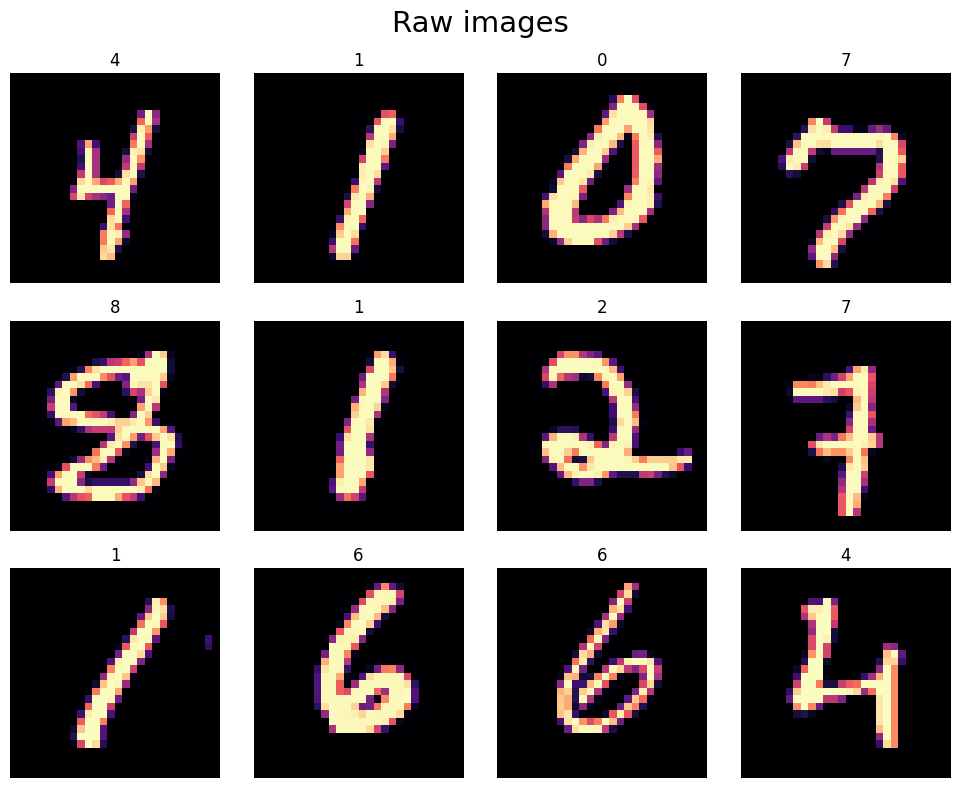

In [4]:
(ds_train_, ds_test_), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
    batch_size=32
)

# show a sample of 12 images from ds_train_
fig, ax = plt.subplots(3, 4, figsize=(10, 8))
# title: raw images
fig.suptitle("Raw images", fontsize=21)

# from 1st batch
(images, labels) = ds_train_.take(1).as_numpy_iterator().next()
# show first 12 images
for i in range(12):
    ax[i//4, i%4].imshow(images[i])
    ax[i//4, i%4].set_title(labels[i])
    ax[i//4, i%4].axis('off')

# log dataset metadata

In [5]:
# get number of classes in ds_train
num_classes = ds_info.features['label'].num_classes

# get total number of training examples
num_train = ds_info.splits['train'].num_examples

print(f"Number of classes: {num_classes}")
print(f"Number of training examples: {num_train}")

wandb.log({
    "number_of_classes": num_classes,
    "number_of_training_examples": num_train})

Number of classes: 10
Number of training examples: 60000


2022-09-25 16:48:34.069886: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-09-25 16:48:34.070142: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


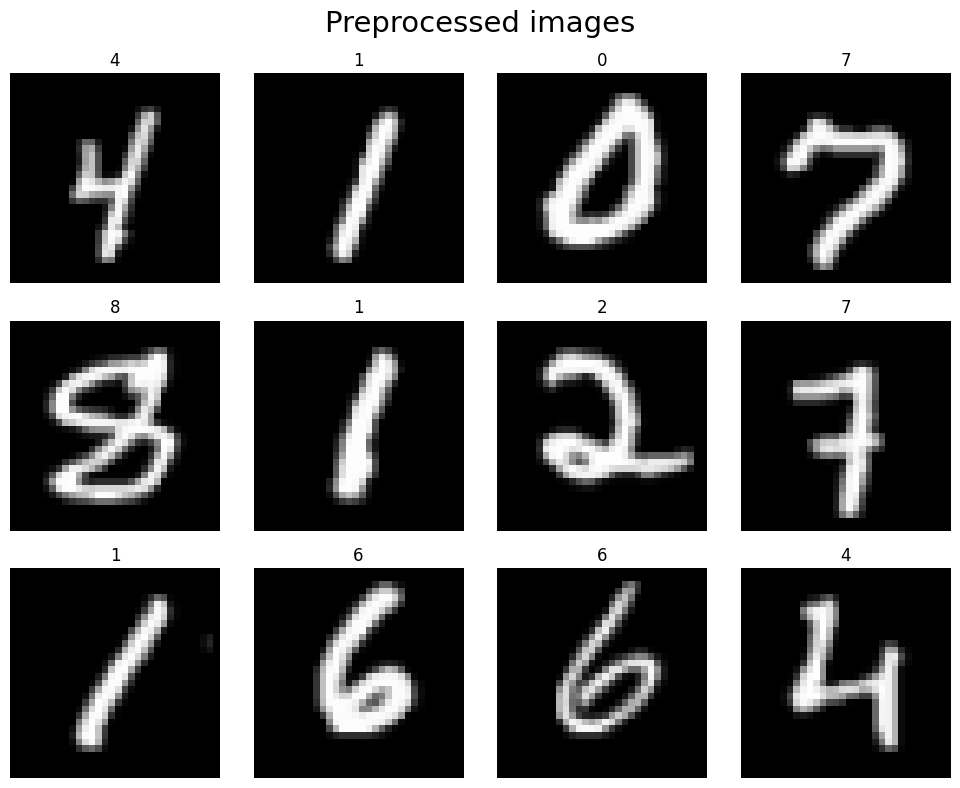

In [6]:
# image preprocessing

def expand_channel_axis(image, label):
    image = tf.expand_dims(image, axis=-1)
    return image, label

def grayscale_to_rgb(image, label):
    # transpose to (32, 32, 1) -> (32, 32, 3)
    #image = tf.tile(image, [1, 1, 3])
    image = tf.image.grayscale_to_rgb(image)
    return image, label

def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

def resize_image(image, label):
    # resize from Nonex28x28x3 to Nonex32x32x3
    image = tf.image.resize(image, (32, 32))
    # expand from (32,32,3) to (1,32,32,3)
    #image = tf.expand_dims(image, axis=0)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .map(grayscale_to_rgb)
    .map(resize_image)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

ds_test = (
    ds_test_
    .map(convert_to_float)
    .map(grayscale_to_rgb)
    .map(resize_image)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

# show a sample of 12 images from ds_train_
fig, ax = plt.subplots(3, 4, figsize=(10, 8))
# title: raw images
fig.suptitle("Preprocessed images", fontsize=21)

# from 1st batch
(images, labels) = ds_train.take(1).as_numpy_iterator().next()
# show first 12 images
for i in range(12):
    ax[i//4, i%4].imshow(images[i], cmap='magma')
    ax[i//4, i%4].set_title(labels[i])
    ax[i//4, i%4].axis('off')

In [7]:
import tensorflow_hub as hub


pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(32,32,3),
                   pooling='avg',classes=5,
                   weights='imagenet')

for layer in pretrained_model.layers:
        layer.trainable=False

model = keras.Sequential([
    pretrained_model,
    layers.Flatten(),
    layers.Dense(12, activation='relu'),
    layers.Dense(12, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['categorical_accuracy'],    
)

In [8]:
'''
ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 32, 32, 3), found shape=(32, 32, 3)
'''
history = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=3,
    batch_size=1,
    callbacks=[WandbCallback()]
)

# wandb log train_loss and val_loss and error_rate
wandb.log({
    "train_loss": history.history['loss'],
    "valid_loss": history.history['val_loss'],
    "error_rate": history.history['categorical_accuracy']
})

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
2022-09-25 16:48:36.103630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-25 16:48:36.103795: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-09-25 16:48:36.103858: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2022-09-25 16:48:36.104090: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Epoch 1/3


2022-09-25 16:48:39.837369: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


   1/1875 [..............................] - ETA: 1:38:13 - loss: 2.6591 - categorical_accuracy: 0.0000e+00

2022-09-25 16:48:40.722514: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-09-25 16:48:40.722546: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-09-25 16:48:40.734220: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-09-25 16:48:40.734238: W tensorflow/core/common_runtime/bfc_allocato

KeyboardInterrupt: 

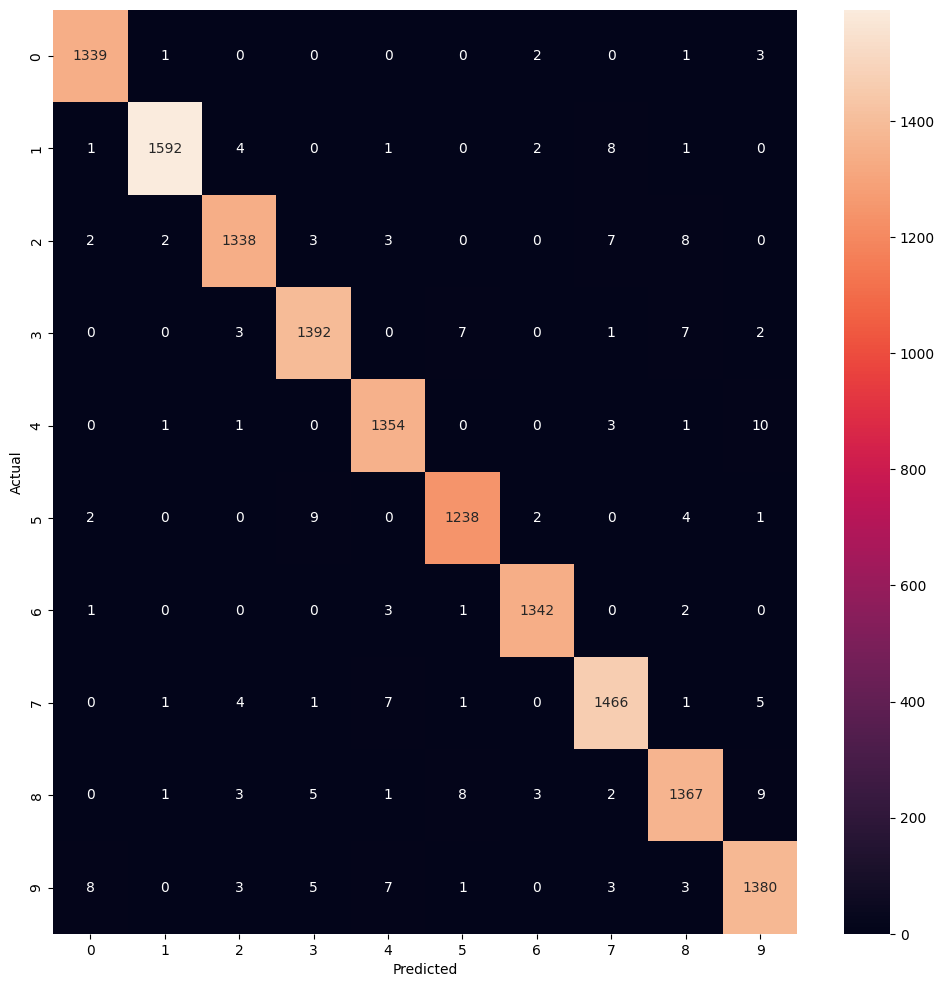

In [ ]:
import seaborn as sns

interp = ClassificationInterpretation.from_learner(learn)
conf_matrix = interp.confusion_matrix()
# plot seaborn confusion matrix with figsize (12,12) and cmap plasma
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="rocket", ax=ax)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

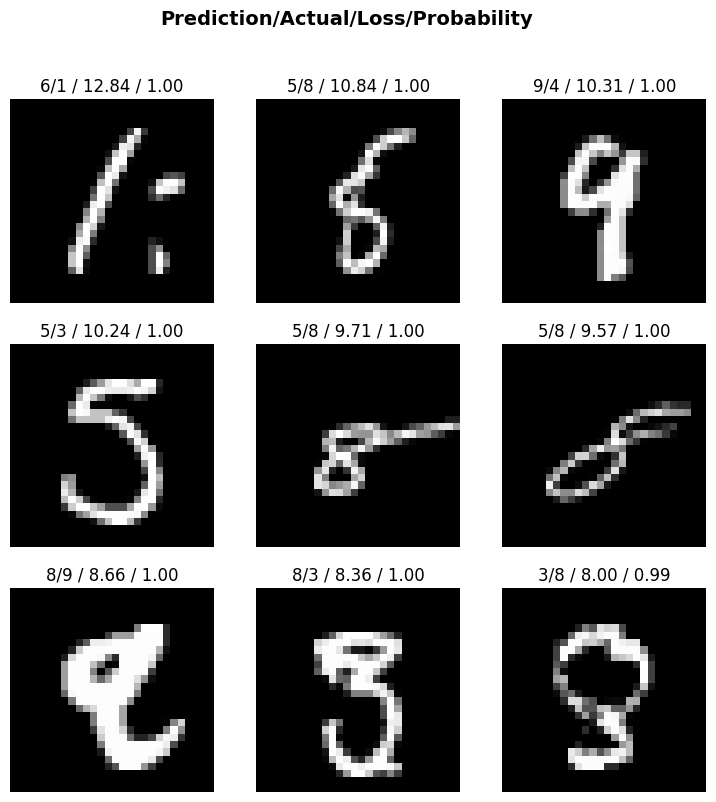

In [ ]:
interp.plot_top_losses(9, nrows=3)

In [ ]:
learn.export('../models/fastai_resnet18_mnist.pkl')

In [ ]:
test_data_path = pathlib.Path("../data/numbers/test")
test_dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    #splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
).dataloaders(test_data_path, bs=32)

In [ ]:
learn2 = load_learner('../models/fastai_resnet18_mnist.pkl') 
learn2.dls = test_dls

In [ ]:
preds, y, decoded = learn.get_preds(with_decoded=True)
# get accuracy
acc = accuracy(preds, y)
print(f"Accuracy: {float(acc)*100:.5f}%")

Accuracy: 98.62857%


In [ ]:
# wandb log confusion matrix

wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None, y_true=y.numpy(), preds=decoded.numpy(), class_names=interp.vocab)})

#